<div style="background-color: beige; padding: 10px;">
<p style='font-size: 22px; text-align: right;'><strong>Stephanie Dragoi and Victor Matsumoto</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>DUE 20231026</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>MLR Project- Used Car Pricing Model</strong></p>
</div>

# Introduction and Car Selection

# Munging and Field Engineering

The torque column had conflicting units; most observations were entered in Nm@rpm, but a few were entered in kgm@rpm, which we changed to Nm@rpm. Some of the torques were given in the format torque@[range of rpms], which we changed to torque@lower_rpm. <br>
<br>
For the engine, max_power, and torque fields, we changed all the values to be expressed to the one's place (ex. 65.01 became 65). <br>
<br>
<br>
One of the models was listed as Tata Indigo VS, which is not a valid model, so we dropped this observation, being unable to match its specifications to the Indigo CS, which was one model to which 'VS' could have plausibly been referring. Three additional Tata Indigo observations were dropped because their model was listed simply as "TDI," which could refer to the quite different Tata Indigo LX (TDI): 2008 - 2011, Tata Indigo LX (TDI) BS-III: 2008 - 2011, Tata Indigo CS LE (TDI) BS-III: 2008 - 2011, or Tata Indigo CS LS (TDI) BS-III: 2008 - 2011. <br>
<br>
Since the engine, max_power, and torque fields give very similar information, they were combined into one field called engine_max_power_torque, with data in this field being in the format "engine max_power torque@x_rpm". However, ultimately, our engineered field showed that choosing engine, max_power, or torque for calculations would be sufficient rather than attempting to use all three, since they essentially measure the same thing.<br>
<br>
Since many of the model names were extremely specific, two fields were created to replace the original model_contd field: one called model_gen, with the general name of the model, such as "CS" for "CS eGLS BS IV," and one with the original, ultra-specific model name, adjusted in a 2-3 cases to omit information like trim. <br>
<br>
Three fields were dropped since all the observations had the same value: make, transmission, and seats. <br>
<br>
<br>
I dropped the "trim" variable because it was considered irrelevant and didn't contribute meaningfully to the model's predictive accuracy.

# Step 4: Import Libraries

In [138]:
# Import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip

# Step 5: Python Functions

In [139]:
# Define useful functions including regression_performance, calculate_vif

def regression_performance(model, X, y):
 yhat = model.predict(X)
 mse = mean_squared_error(y, yhat)
 mae = mean_absolute_error(y, yhat)
 mape = np.mean(np.abs(y - yhat) / y) * 100 # mean absolute pct. error
 df_performance_summary = pd.DataFrame(
 {"MSE": mse, "MAE": mae, "MAPE": mape}, index=[0])
 return df_performance_summary

# Function to return a dataframe showing the VIF for each explanatory variable:
# Note that the explanatory variables are in a dataframe called Xdataframe.
def calculate_vif(Xdataframe):
 temp_df = pd.DataFrame()
 temp_df["column name"] = Xdataframe.columns
 temp_df["VIF"] = [variance_inflation_factor(Xdataframe.values, k)
 for k in range(len(Xdataframe.columns))]
 return temp_df

# Step 6: Dataframe Summary Statistics

In [140]:
# read csv and describe
df = pd.read_csv('Munged and Engineered Car data.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,284.0,2010.904930,2.944980,2003.000000,2009.00000,2011.00000,2013.00000,2018.0000
asking_price,284.0,8935.902465,4133.273001,2000.000000,5699.96250,8500.00000,11424.95000,22500.0000
miles_driven,284.0,59907.544600,27672.469662,7454.545455,42708.33333,55909.09091,74545.45455,168348.4848
num_previous_owners,284.0,1.665493,0.735812,1.000000,1.00000,2.00000,2.00000,4.0000


# Step 7: Variable Types and Missing Data

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    284 non-null    object 
 1   model_gen                284 non-null    object 
 2   model_spec               284 non-null    object 
 3   year                     284 non-null    int64  
 4   asking_price             284 non-null    float64
 5   miles_driven             284 non-null    float64
 6   fuel                     284 non-null    object 
 7   seller_type              284 non-null    object 
 8   num_previous_owners      284 non-null    int64  
 9   mileage                  284 non-null    object 
 10  engine                   284 non-null    object 
 11  max_power                284 non-null    object 
 12  torque                   284 non-null    object 
 13  engine_max_power_torque  284 non-null    object 
dtypes: float64(2), int64(2), o

Most fields are of type object, with a few being int64 or float64. There is no missing data, since all of it has been handled using imputation (see step 8).

# Step 8: Missing Data Treatment

Missing data was treated in the spreadsheet using imputation. 5 observations of make/model Tata Indica DLS, 1 observation of make/model Tata Indica DLX, 5 observations of make/model Tata Indica Vista Aqua 1.3 Quadrajet (ABS), and 2 observations of make/model Tata Indica Vista Quadrajet LS were missing values for the following fields: <br>
* mileage
* engine
* max_power
* torque
* seats
<br>
<br>
The missing values were imputed using information from the websites CarFolio and CarWale, which provided information for the above fields based on make and model.

# Step 9: Categorical Conversion

In [142]:
# Convert all variables that are logically categorical, except for model year, into true categories
# Code from official Pandas documentation on categorical data

categorical_columns = ['model', 'model_gen', 'model_spec','fuel','seller_type','num_previous_owners','mileage','engine','max_power','torque']
df[categorical_columns] = df[categorical_columns].astype('category')

# Step 10: Explanatory/Target Split

In [143]:
# split data into explanatory matrix (X) and target column (y)

X = df.drop(['asking_price'], axis = 1)
y = df['asking_price']

# Step 11: Dummy Variables for Categorical Values

In [144]:
# Perform one-hot encoding for all categorical values

X = X.drop(['max_power', 'torque', 'engine_max_power_torque'], axis = 1)
print(X.columns)
# Perform one-hot encoding for all categorical values
X_encoded = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object","category"]).columns.tolist(),
    drop_first=True
)
X_encoded = X_encoded.drop(['year','miles_driven'], axis = 1)

# Combine the original columns and one-hot encoding columns
X = pd.concat([X, X_encoded], axis=1)
X

Index(['model', 'model_gen', 'model_spec', 'year', 'miles_driven', 'fuel',
       'seller_type', 'num_previous_owners', 'mileage', 'engine'],
      dtype='object')


,model,model_gen,model_spec,year,miles_driven,fuel,seller_type,num_previous_owners,mileage,engine,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
0,Indigo,eCS,CR4,2011,52381.22727,Diesel,Individual,1,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
1,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
2,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
3,Indigo,eCS,eCS CR4,2011,31060.60606,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
4,Indigo,eCS,eCS CR4,2011,108712.12120,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Indica,Vista,Vista Terra 1.4 TDI,2011,49696.96970,Diesel,Individual,1,17.0 kmpl,1405 CC,...,0,0,0,0,0,0,0,0,0,1
280,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,74545.45455,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
281,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,62121.21212,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
282,Indica,Vista,Vista Terra Quadrajet 1.3L,2011,54045.45455,Diesel,Individual,1,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0


# Step 12: Preliminary EDA

## Create Histograms and Modified Boxplots or Bar Graphs for All Fields

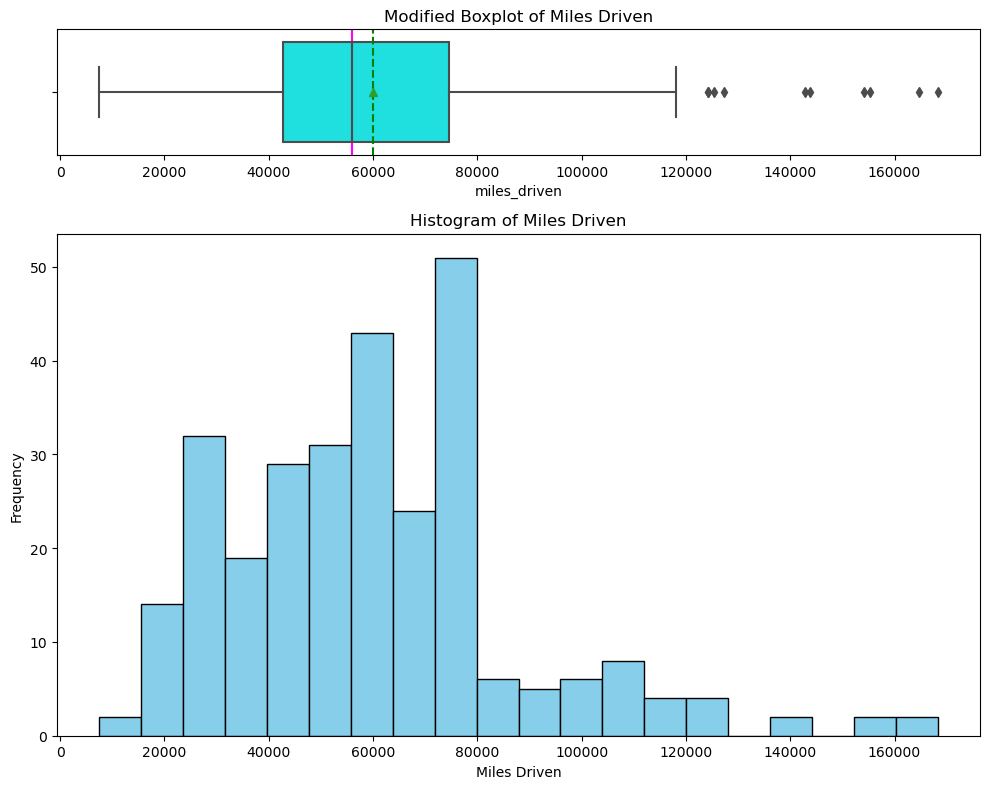

In India (according to this article https://timesofindia.indiatimes.com/business/india-business/drive-12k-km-a-year-cheaper-to-call-cab/articleshow/59979877.cms) the average miles a driver drives in a year is about 12000km or 7456.4543 miles. If you multiply that by the difference betweeen the 2022 as thats when most of these were probably put up for sale and the year it was made + 1 as not all cars are immediately sold and then add 10000 you will get a general estimate of the miles driven. Based off that since most of the cars are made in 2012 if you use that with the formula i made you will get about 77500 miles which matches up with the graph


In [145]:

# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'miles_driven'
sns.boxplot(x=df['miles_driven'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Miles Driven')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['miles_driven']), color='green', linestyle='--')
ax_box.axvline(np.median(df['miles_driven']), color='magenta', linestyle='-')

# Create a histogram for 'miles_driven'
ax_hist.hist(df['miles_driven'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Miles Driven')
ax_hist.set_xlabel('Miles Driven')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()
print("In India (according to this article https://timesofindia.indiatimes.com/business/india-business/drive-12k-km-a-year-cheaper-to-call-cab/articleshow/59979877.cms) the average miles a driver drives in a year is about 12000km or 7456.4543 miles. If you multiply that by the difference betweeen the 2022 as thats when most of these were probably put up for sale and the year it was made + 1 as not all cars are immediately sold and then add 10000 you will get a general estimate of the miles driven. Based off that since most of the cars are made in 2012 if you use that with the formula i made you will get about 77500 miles which matches up with the graph")

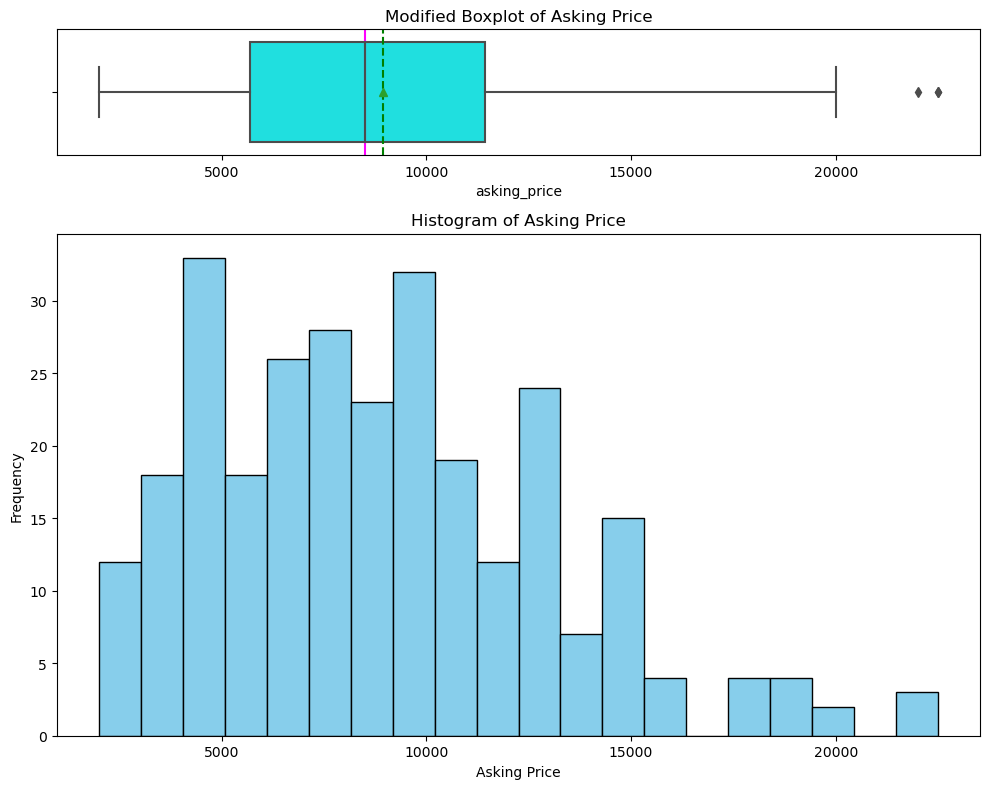

The average asking price in the dataset is approximately $6,947.11, with a median asking price of $7,500. The majority of prices fall within the range of about $6,000 to $12,000, indicating a common pricing range. Notably, there are two significant outliers in the dataset, both exceeding $20,000, which stand out as exceptions to the typical pricing pattern. The graph is also right skewed with a gap between about 15000 and 20000 as it seperates probably the newer expensive cars and modified cars that are really expensive.


In [146]:
# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'asking_price'
sns.boxplot(x=df['asking_price'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Asking Price')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['asking_price']), color='green', linestyle='--')
ax_box.axvline(np.median(df['asking_price']), color='magenta', linestyle='-')

# Create a histogram for 'asking_price'
ax_hist.hist(df['asking_price'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Asking Price')
ax_hist.set_xlabel('Asking Price')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()
print("The average asking price in the dataset is approximately $6,947.11, with a median asking price of $7,500. The majority of prices fall within the range of about $6,000 to $12,000, indicating a common pricing range. Notably, there are two significant outliers in the dataset, both exceeding $20,000, which stand out as exceptions to the typical pricing pattern. The graph is also right skewed with a gap between about 15000 and 20000 as it seperates probably the newer expensive cars and modified cars that are really expensive.")

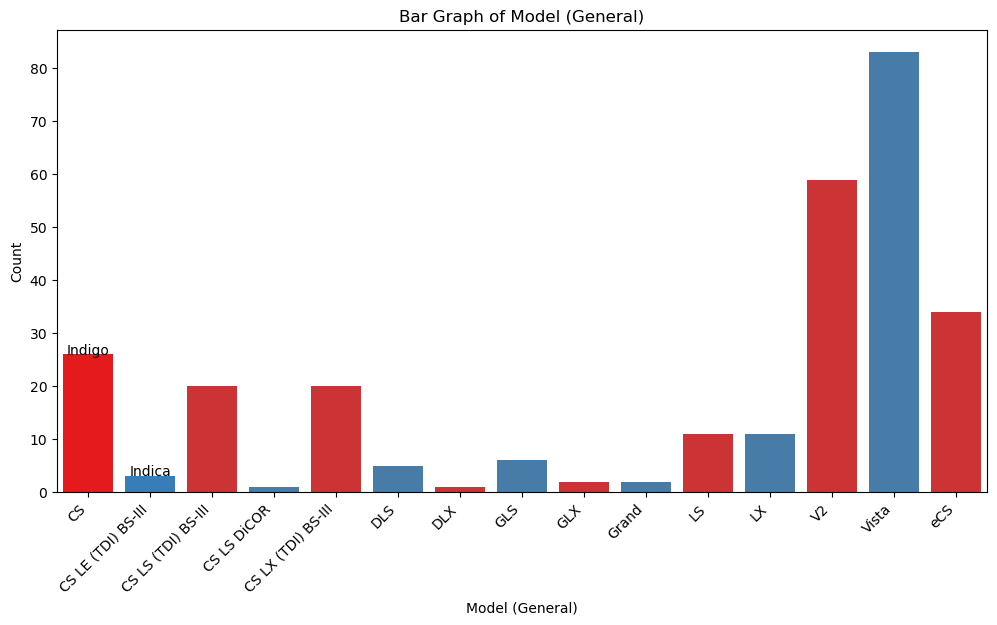

Whilst 15 models exist for these cars 8 being for indigo and 7 for indica, the three most common ones are Vista with over 80, V2 with over 50, and eCS with over 30.


In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_gen' column
model_gen_counts = df['model_gen'].value_counts()

# Create a color map for 'model' field
colors = sns.color_palette("Set1", n_colors=len(df['model'].unique()))

# Create a bar graph with colors based on 'model'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_gen_counts.index, y=model_gen_counts.values, palette=colors)
plt.title('Bar Graph of Model (General)')
plt.xlabel('Model (General)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add a legend for 'model' values
for patch, label in zip(ax.patches, df['model'].unique()):
    color = colors[df['model'].unique().tolist().index(label)]
    patch.set_facecolor(color)
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), label, ha='center', color='black')

plt.show()
print("Whilst 15 models exist for these cars 8 being for indigo and 7 for indica, the three most common ones are Vista with over 80, V2 with over 50, and eCS with over 30.")

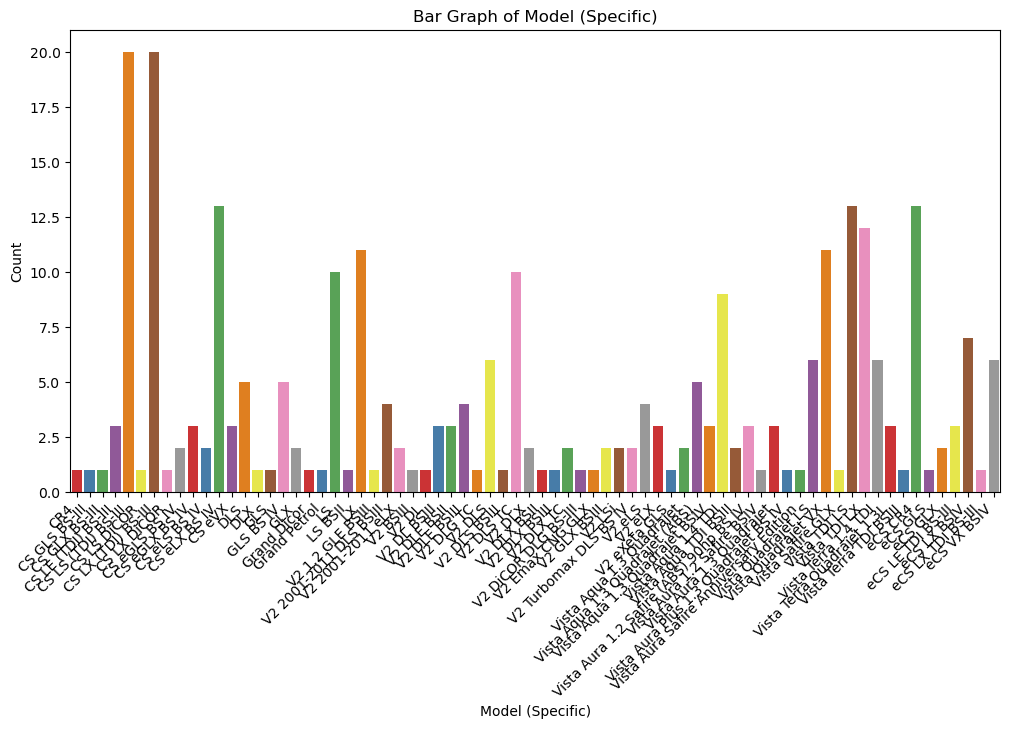

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_spec' column
model_spec_counts = df['model_spec'].value_counts()

# Create a bar graph for 'model_spec'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_spec_counts.index, y=model_spec_counts.values, palette="Set1")
plt.title('Bar Graph of Model (Specific)')
plt.xlabel('Model (Specific)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

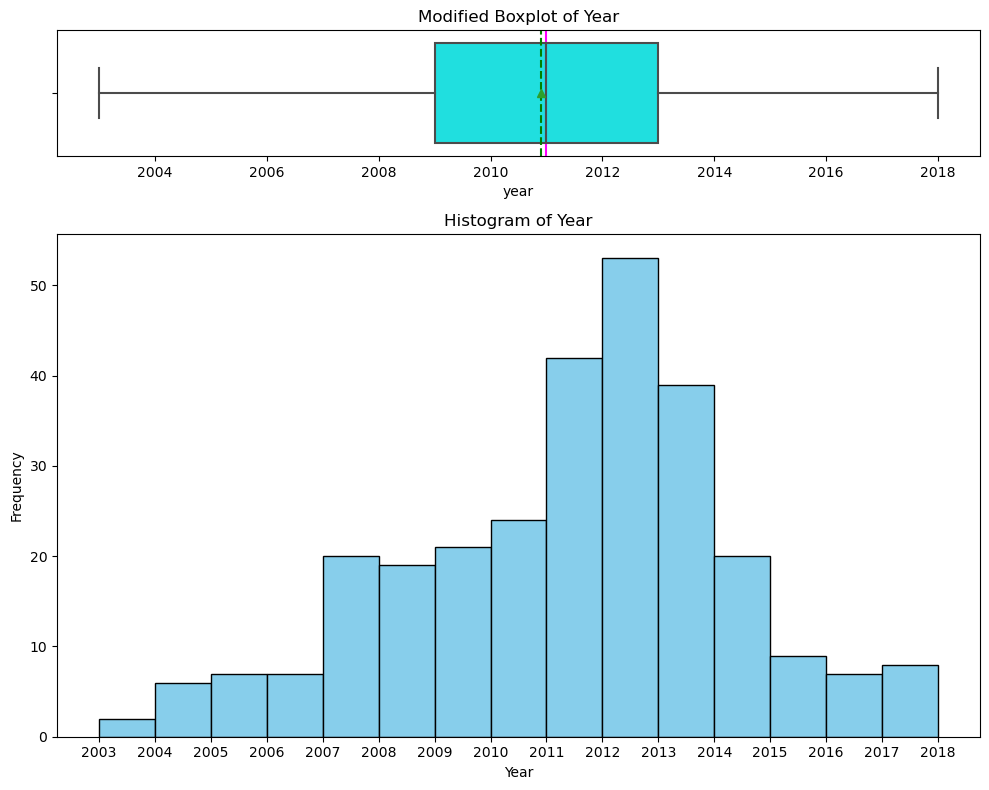

This graph is left skewed and has an average around 2011 which is because if the car is super old not many people have it but if its a newer model not many people want to sell it. most of the cars were made between around 2009 and 2013.


In [149]:
# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'year'
sns.boxplot(x=df['year'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Year')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['year']), color='green', linestyle='--')
ax_box.axvline(np.median(df['year']), color='magenta', linestyle='-')

# Create a histogram for 'year' with specified bins to align with bars
bins = range(int(min(df['year'])), int(max(df['year'])) + 1)
ax_hist.hist(df['year'], bins=bins, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Year')
ax_hist.set_xlabel('Year')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Set the x-axis ticks to align with bars
ax_hist.set_xticks(bins)

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()
print("This graph is left skewed and has an average around 2011 which is because if the car is super old not many people have it but if its a newer model not many people want to sell it. most of the cars were made between around 2009 and 2013.")

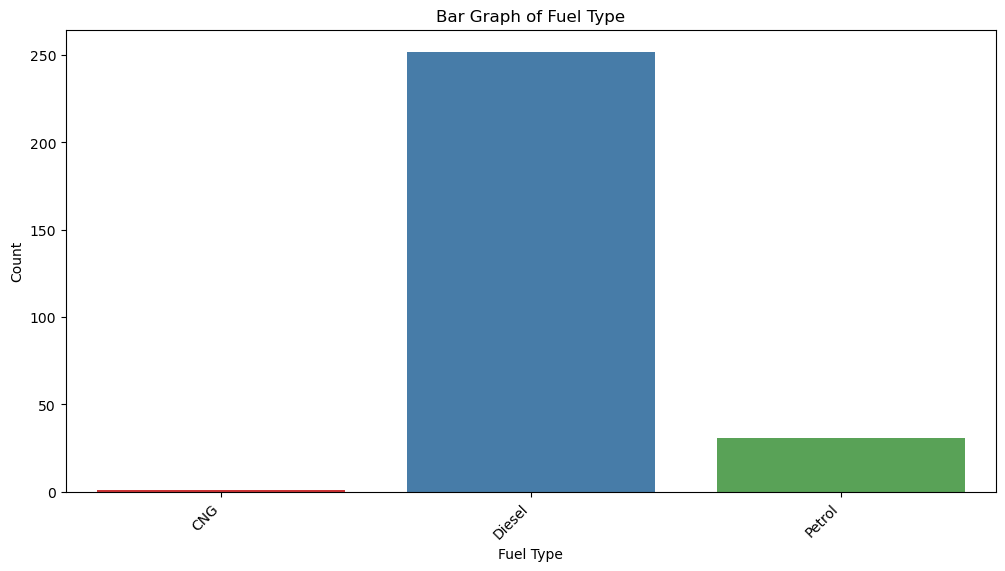

Most of these cars run on diesel as most models of the car use diesel with less than 50 taking petrol. The outlier here is CNG as only one specific model the V2 Emax CNG GLX takes CNG.


In [150]:
# Create a bar graph for 'fuel'
fuel_counts = df['fuel'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="Set1")
plt.title('Bar Graph of Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print("Most of these cars run on diesel as most models of the car use diesel with less than 50 taking petrol. The outlier here is CNG as only one specific model the V2 Emax CNG GLX takes CNG.")

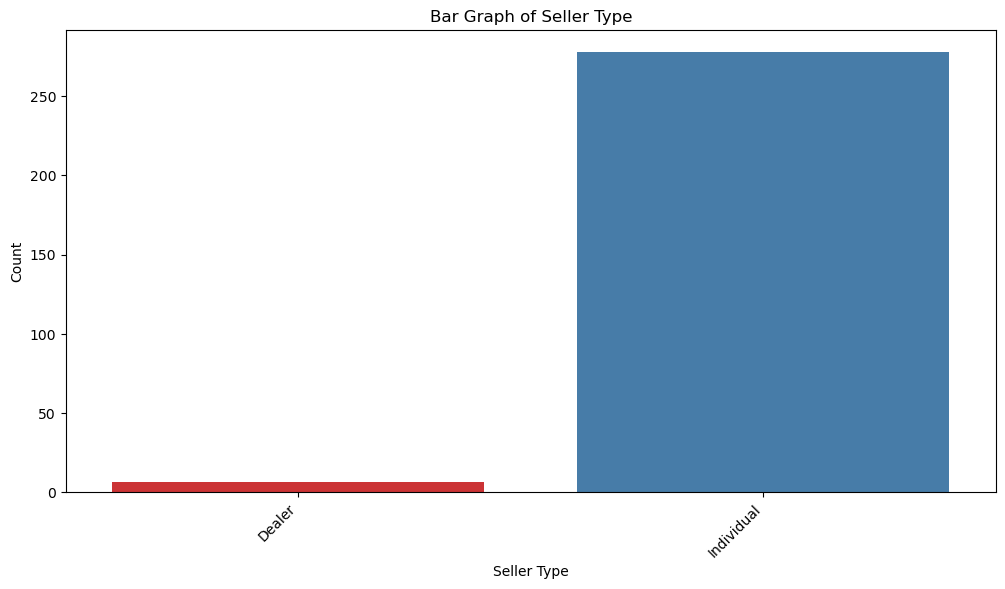

The reason an overwhelming majority of these cars are sold by individuals not dealerships are because they are mostly in India and India dosen't have many used car dealerships.


In [151]:
# Create a bar graph for 'seller_type'
seller_type_counts = df['seller_type'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=seller_type_counts.index, y=seller_type_counts.values, palette="Set1")
plt.title('Bar Graph of Seller Type')
plt.xlabel('Seller Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print("The reason an overwhelming majority of these cars are sold by individuals not dealerships are because they are mostly in India and India dosen't have many used car dealerships.")

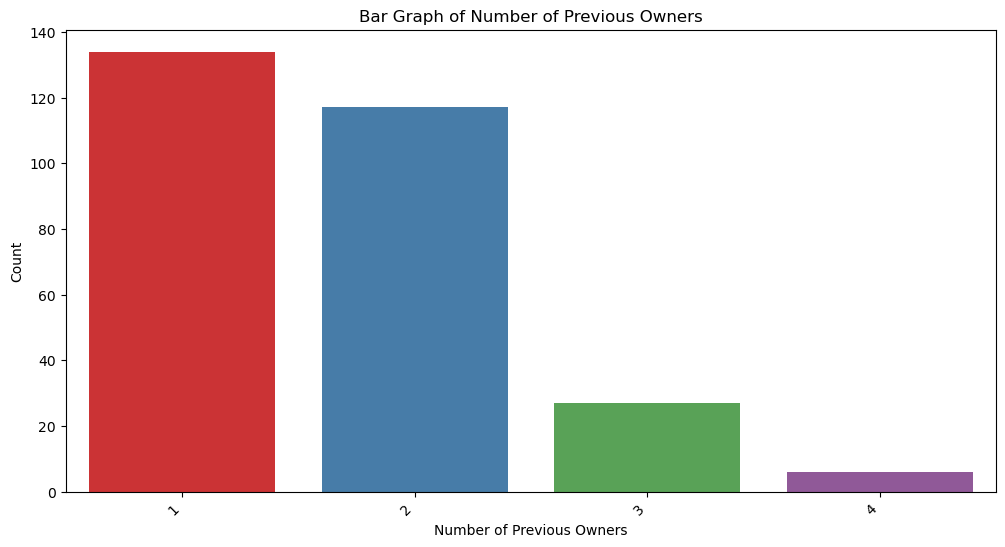

Most of these cars have 1 or 2 owners, because usually an owner will drive the car around for a few years before selling it and since there are not many very old cars the time restrictions make most of them 1 or 2 previous owners.


In [152]:
# Create a bar graph for 'num_previous_owners'
num_previous_owners_counts = df['num_previous_owners'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=num_previous_owners_counts.index, y=num_previous_owners_counts.values, palette="Set1")
plt.title('Bar Graph of Number of Previous Owners')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print("Most of these cars have 1 or 2 owners, because usually an owner will drive the car around for a few years before selling it and since there are not many very old cars the time restrictions make most of them 1 or 2 previous owners.")

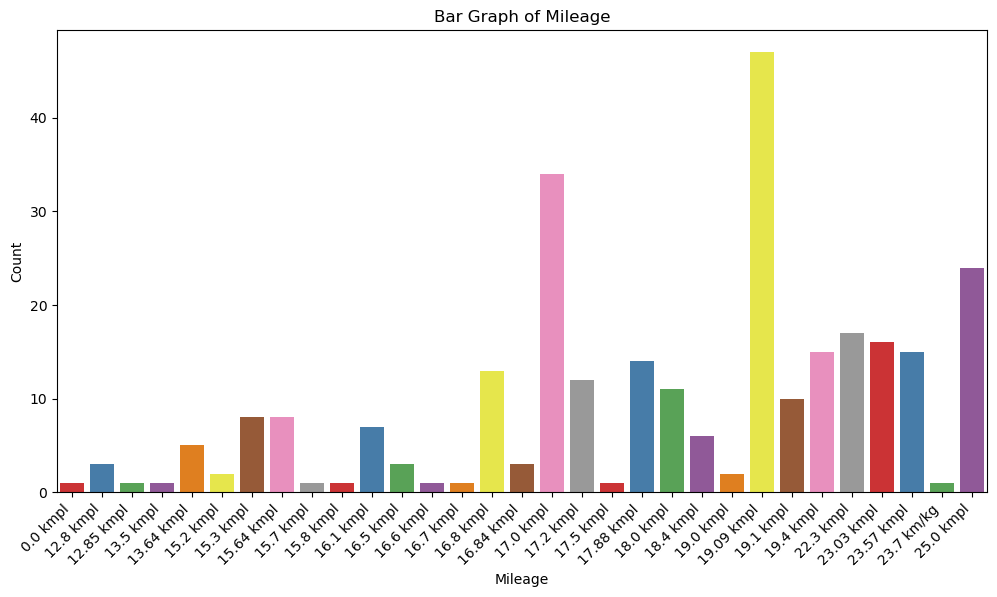

The mileage of these cars usually vary by model, but some have a slightly different ones for varying reasons.


In [153]:
# Create a bar graph for 'mileage'
mileage_counts = df['mileage'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mileage_counts.index, y=mileage_counts.values, palette="Set1")
plt.title('Bar Graph of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print("The mileage of these cars usually vary by model, but some have a slightly different ones for varying reasons.")

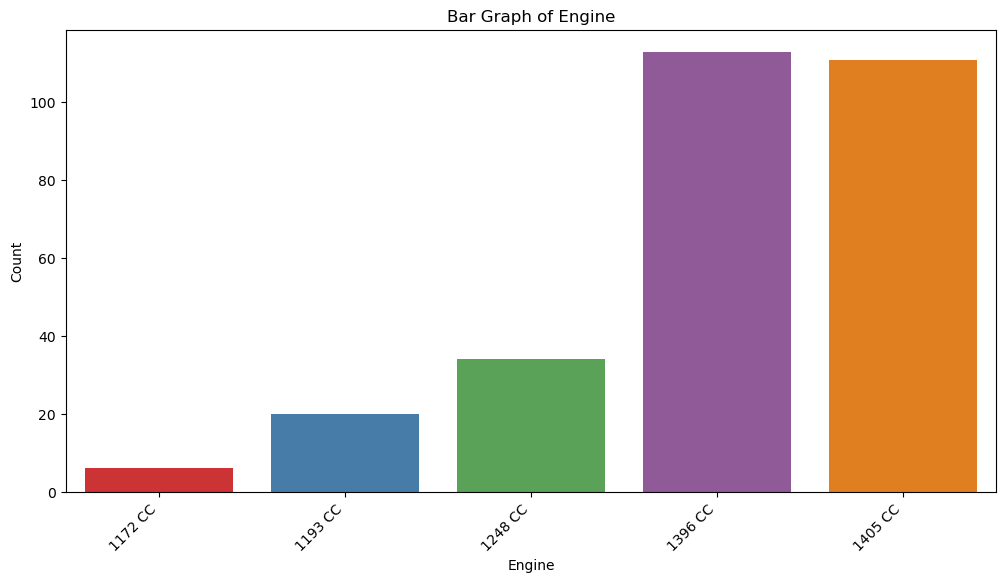

The enginge of most cars are either 1396 CC or 1405 CC with over 200 being in those categories.


In [154]:
# Create a bar graph for 'engine'
engine_counts = df['engine'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=engine_counts.index, y=engine_counts.values, palette="Set1")
plt.title('Bar Graph of Engine')
plt.xlabel('Engine')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print("The enginge of most cars are either 1396 CC or 1405 CC with over 200 being in those categories.")

# Step 13: Outlier and Skewness Treatment

Outliers, specifically those observed in the modified boxplots, seller type, and fuel type visualizations were kept in with the data. One reason for this was the already limited number of observations.

# Step 14: Continuation of EDA

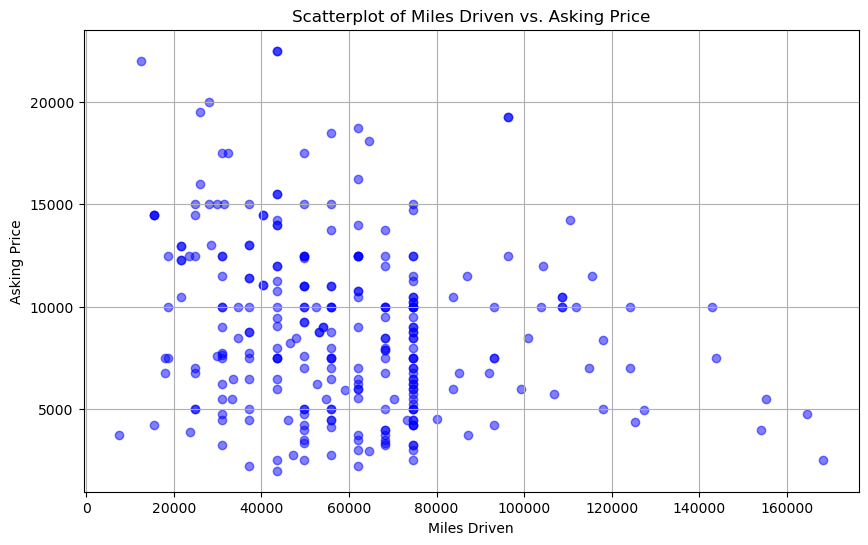

In [155]:
# Create a scatterplot of 'miles driven' vs. 'asking price'
plt.figure(figsize=(10, 6))
plt.scatter(df['miles_driven'], df['asking_price'], alpha=0.5, color='b', marker='o')
plt.title('Scatterplot of Miles Driven vs. Asking Price')
plt.xlabel('Miles Driven')
plt.ylabel('Asking Price')
plt.grid(True)

# Show the scatterplot
plt.show()


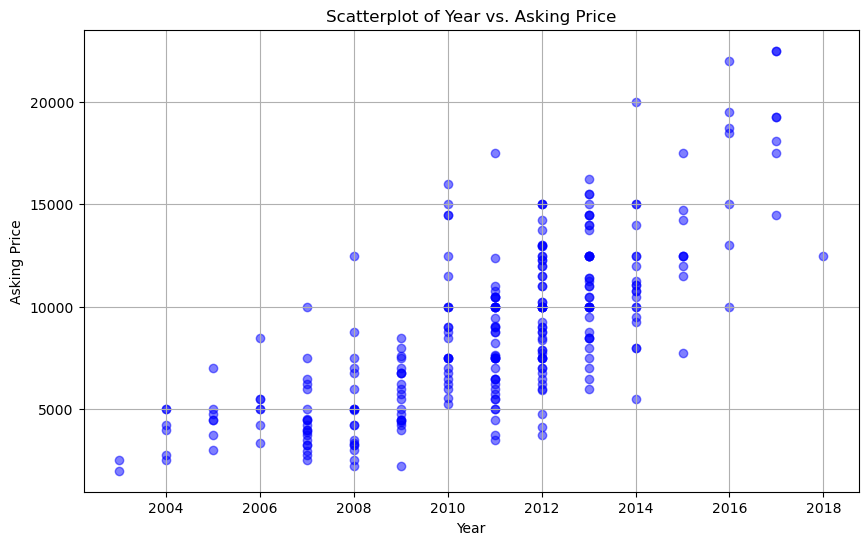

In [156]:
# Create a scatterplot of 'year' vs. 'asking price'
plt.figure(figsize=(10, 6))
plt.scatter(df['year'], df['asking_price'], alpha=0.5, color='b', marker='o')
plt.title('Scatterplot of Year vs. Asking Price')
plt.xlabel('Year')
plt.ylabel('Asking Price')
plt.grid(True)

# Show the scatterplot
plt.show()


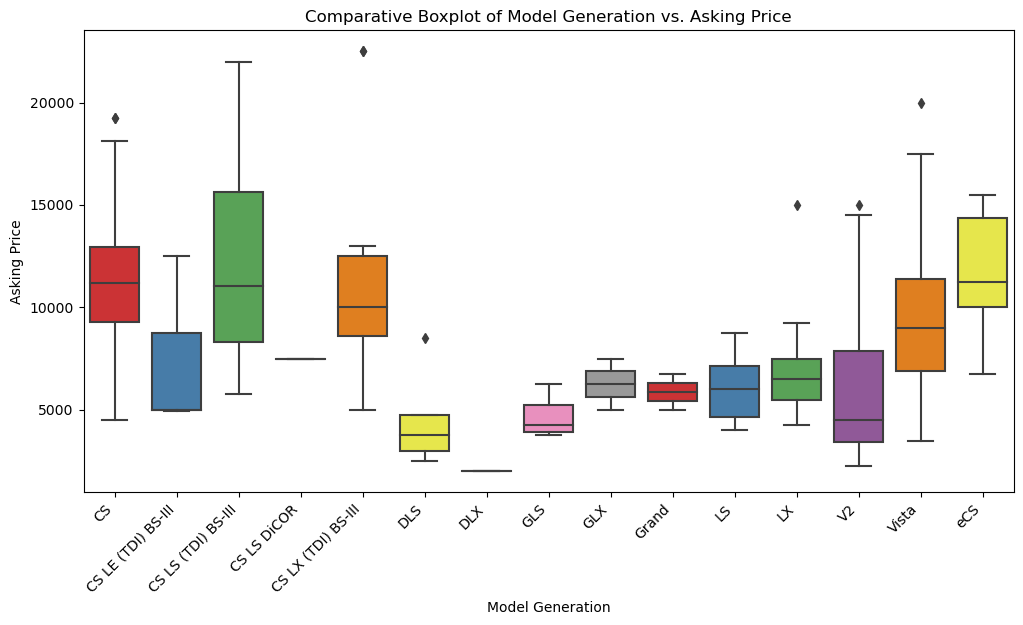

In [157]:
# Create a comparative boxplot of 'model_gen' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model_gen', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Model Generation vs. Asking Price')
plt.xlabel('Model Generation')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


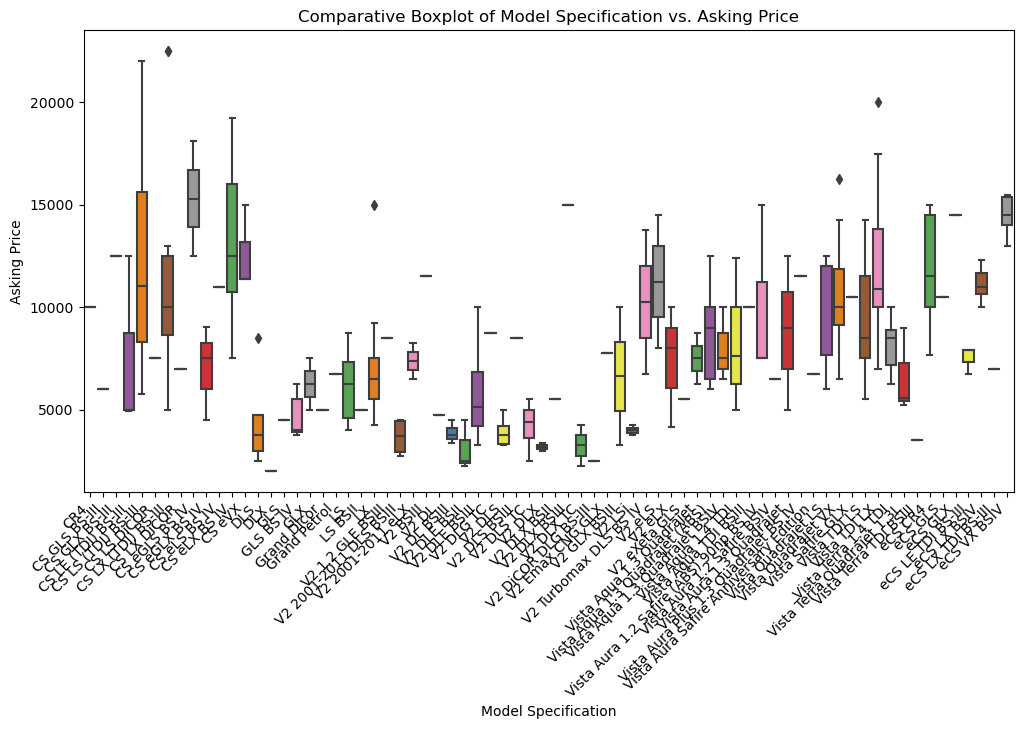

In [158]:
# Create a comparative boxplot of 'model_spec' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model_spec', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Model Specification vs. Asking Price')
plt.xlabel('Model Specification')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


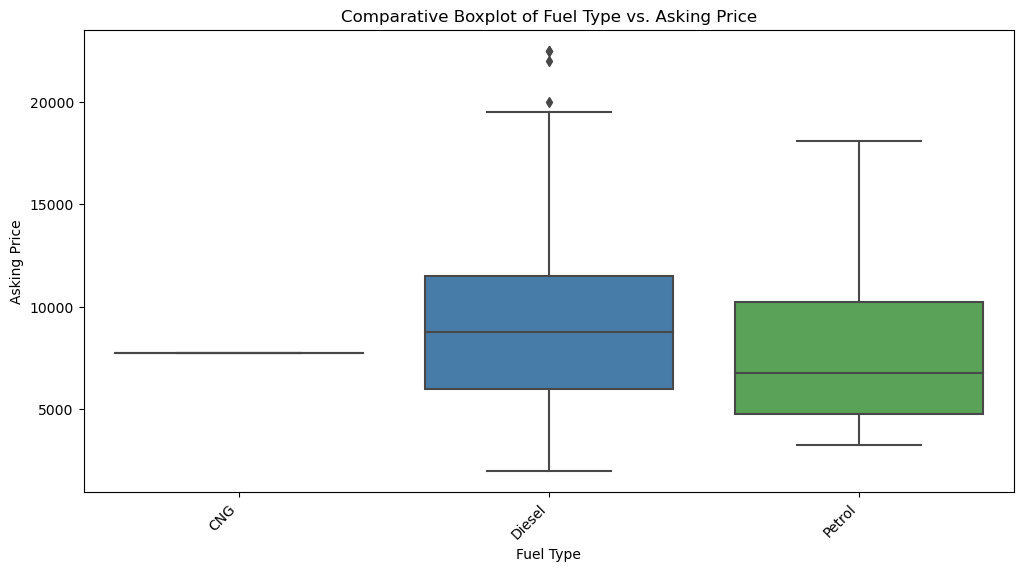

In [159]:
# Create a comparative boxplot of 'fuel_type' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='fuel', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Fuel Type vs. Asking Price')
plt.xlabel('Fuel Type')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


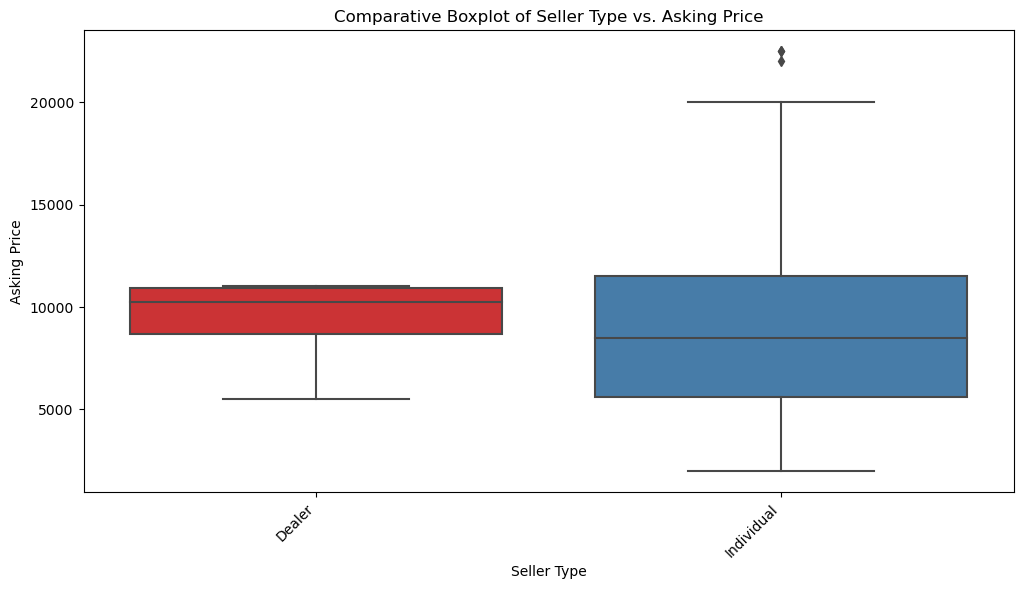

In [160]:
# Create a comparative boxplot of 'seller_type' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='seller_type', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Seller Type vs. Asking Price')
plt.xlabel('Seller Type')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


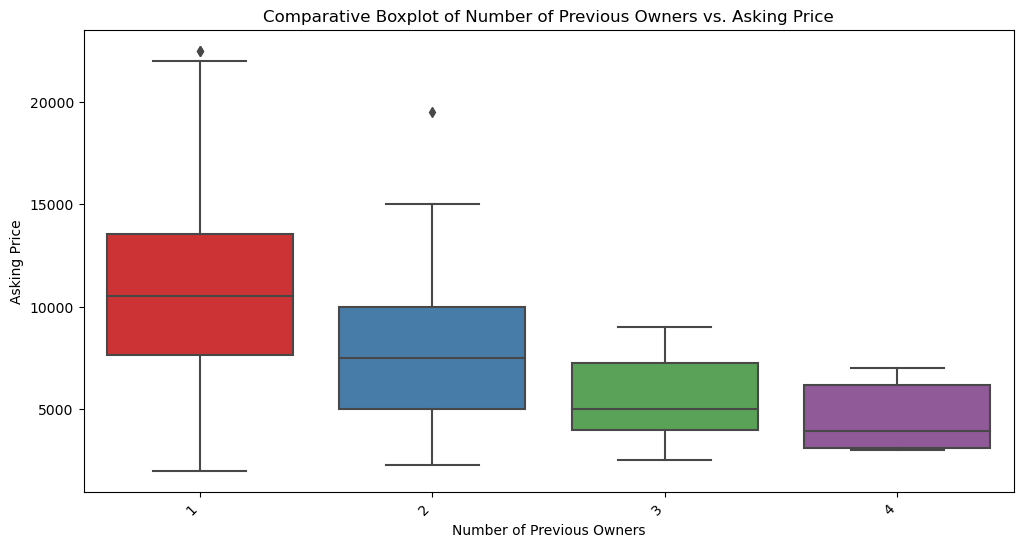

In [161]:
# Create a comparative boxplot of 'num_previous_owners' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='num_previous_owners', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Number of Previous Owners vs. Asking Price')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


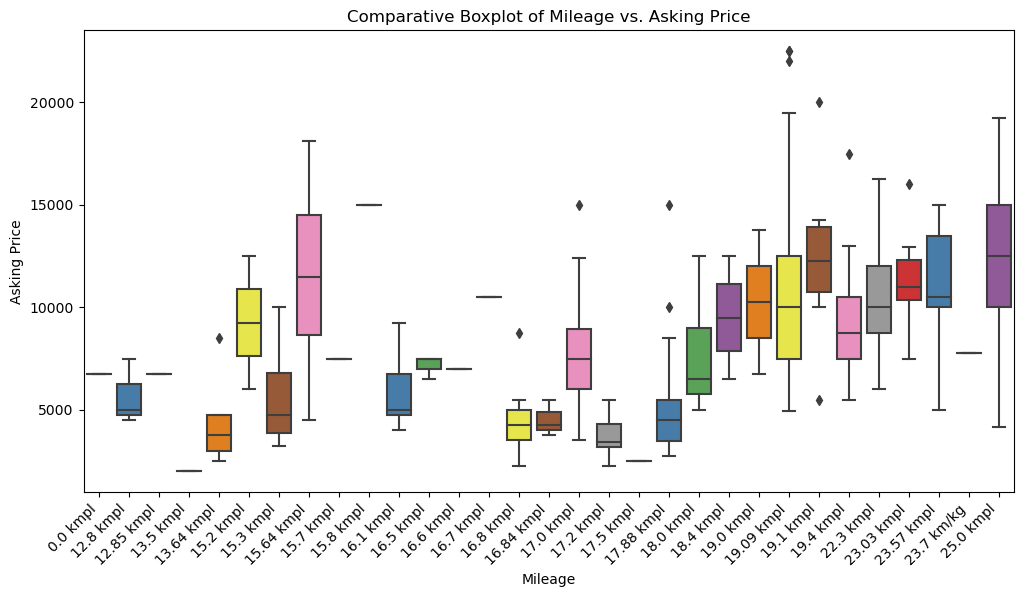

In [162]:
# Create a comparative boxplot of 'mileage' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='mileage', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Mileage vs. Asking Price')
plt.xlabel('Mileage')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

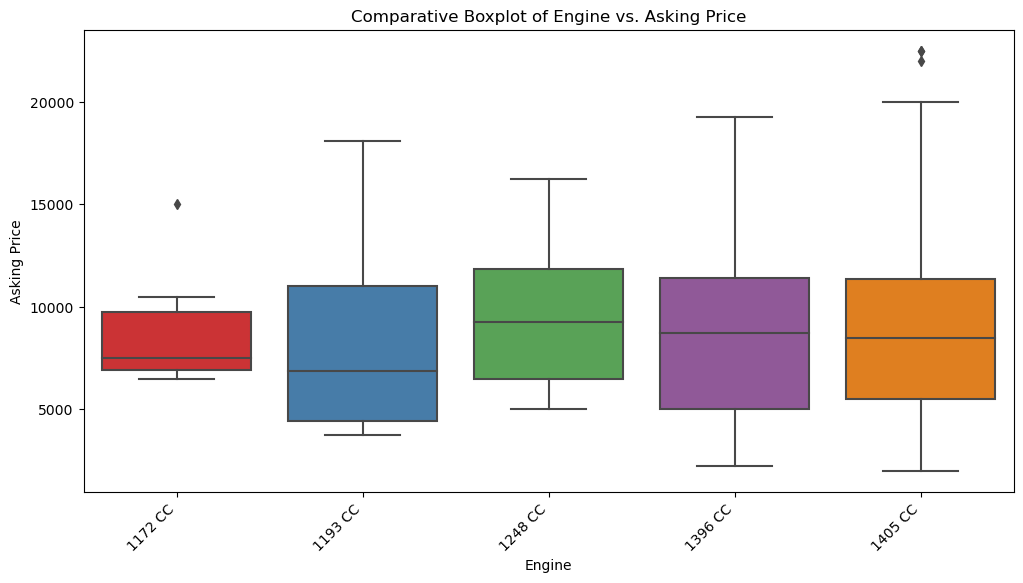

In [163]:
# Create a comparative boxplot of 'engine' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='engine', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Engine vs. Asking Price')
plt.xlabel('Engine')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


# Step 15: Correlation Heatmap

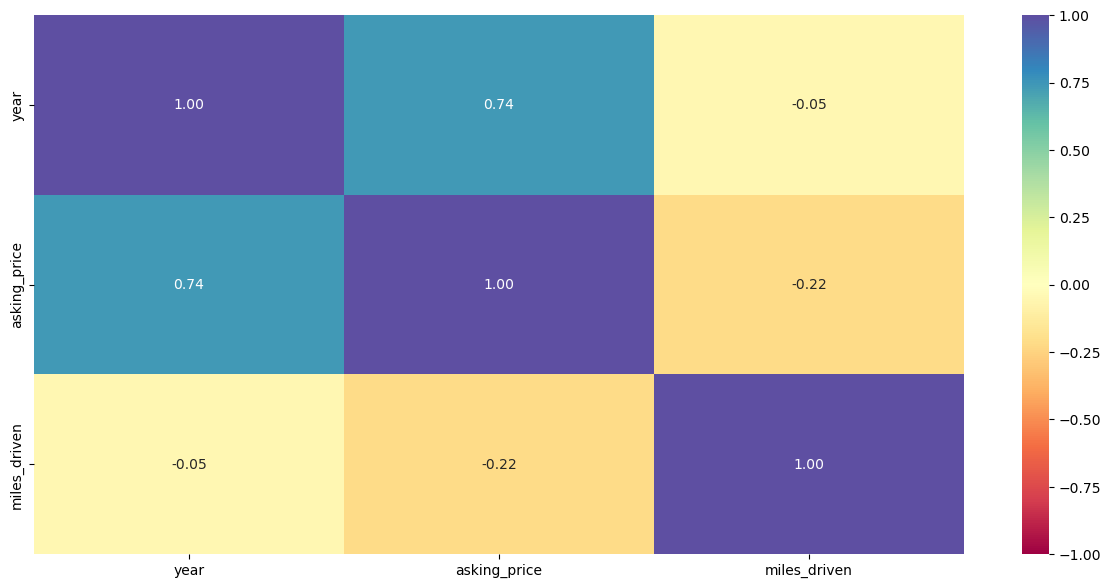

In [164]:
list_of_numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 7))
sns.heatmap(
 df[list_of_numeric_columns].corr(), annot=True,
 vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

# Step 16: Interpretation of Heatmap

Since there will be three boxes wherein the category is the same those all have a one to one correlation and as we can see asking price and years relation is pretty good because generally the asking price will be higher if its a newer model. On the other hand the asking price will go down the more miles have been driven on the car (especially when adjusted for year). <BR>

# Step 17: Pruning of Explanatory Variables

In [165]:
columns_to_drop = [col for col in X.columns if 'model_spec' in col]
X = X.drop(columns_to_drop, axis=1)
X = X.drop(['model','model_gen','fuel', 'seller_type', 'num_previous_owners', 'mileage', 'engine'], axis = 1)
X

,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,model_gen_GLS,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
0,2011,52381.22727,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,2011,43484.84848,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2011,43484.84848,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,2011,31060.60606,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,2011,108712.12120,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2011,49696.96970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
280,2010,74545.45455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
281,2010,62121.21212,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
282,2011,54045.45455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Step 18: Train/Test Split

In [166]:
# Split the data into training and test data using a 75-25 split. This was chosen over a 70-30 split since the amount of data is already limited compared to the ideal amount of 300 observations
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2112)

### Extra Credit: Confirming all columns in X have some variance

In [167]:
# Initialize a flag to check for differences of 0
has_difference_zero = False

# Loop through each column
for column in X.columns:
    # Compute the minimum and maximum values for the column
    column_min = X[column].min()
    column_max = X[column].max()

    # Check if the difference is zero
    if column_min == column_max:
        has_difference_zero = True
        print(f"Error: Column '{column}' has a difference of 0 (min = max)")

# Check if any differences of 0 were found
if has_difference_zero:
    print("Error: At least one column has a difference of 0.")
else:
    print("OK: No differences of 0 found in any column.")


OK: No differences of 0 found in any column.


In [168]:
# Add constant column to both training and test dataframes
Xtrain = sm.add_constant(Xtrain)
Xtest = sm.add_constant(Xtest)

# Step 19: Preliminary OLS Model

In [169]:
# Build OLS model and display statistical summary
model0 = sm.OLS(ytrain,Xtrain).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     10.65
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           6.34e-29
Time:                        09:54:57   Log-Likelihood:                -1791.9
No. Observations:                 198   AIC:                             3676.
Df Residuals:                     152   BIC:                             3827.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 15 p-values > 0.05

# Step 20: Significance Analysis and Revised OLS Models

## Attempt 1

In [170]:
# Try dropping mileage_16.5 kmpl
columns_to_drop = ['mileage_16.5 kmpl']
Xtrain1 = Xtrain.drop(columns_to_drop, axis=1)

In [171]:
# Build OLS model and display statistical summary
model1 = sm.OLS(ytrain,Xtrain1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     10.96
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.90e-29
Time:                        09:54:57   Log-Likelihood:                -1791.9
No. Observations:                 198   AIC:                             3674.
Df Residuals:                     153   BIC:                             3822.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 13 p-values > 0.05 after dropping only mileage_16.5 kmpl; r^2 = 0.693

## Attempt 2

In [172]:
# Try dropping mileage_12.85 kmpl
columns_to_drop = ['mileage_12.85 kmpl']
Xtrain2 = Xtrain1.drop(columns_to_drop, axis=1)

In [173]:
# Build OLS model and display statistical summary
model2 = sm.OLS(ytrain,Xtrain2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     10.96
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.90e-29
Time:                        09:54:58   Log-Likelihood:                -1791.9
No. Observations:                 198   AIC:                             3674.
Df Residuals:                     153   BIC:                             3822.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 12 p-values > 0.05 after also dropping mileage_12.85 kmpl; adjusted r^2 = 0.693

## Attempt 3

In [174]:
# Try dropping mileage_15.3 kmpl
columns_to_drop = ['mileage_15.3 kmpl']
Xtrain3 = Xtrain2.drop(columns_to_drop, axis=1)

In [175]:
# Build OLS model and display statistical summary
model3 = sm.OLS(ytrain,Xtrain3).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     11.29
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           5.60e-30
Time:                        09:54:58   Log-Likelihood:                -1791.9
No. Observations:                 198   AIC:                             3672.
Df Residuals:                     154   BIC:                             3816.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 12 p-values > 0.05 after also dropping mileage_15.3 kmpl; higher adjusted r^2 now of 0.695

## Attempt 4

In [176]:
# Try dropping seller_type_Individual
columns_to_drop = ['seller_type_Individual']
Xtrain4 = Xtrain3.drop(columns_to_drop, axis=1)

In [177]:
# Build OLS model and display statistical summary
model4 = sm.OLS(ytrain,Xtrain4).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     11.62
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.76e-30
Time:                        09:54:58   Log-Likelihood:                -1792.0
No. Observations:                 198   AIC:                             3670.
Df Residuals:                     155   BIC:                             3811.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 10 p-values > 0.05 after also dropping seller_type_Individual; higher adjusted r^2 value of 0.696

## Attempt 5

In [178]:
# Try dropping mileage_15.2 kmpl REMOVED REMOVED REMOVED
columns_to_drop = []
Xtrain5 = Xtrain4.drop(columns_to_drop, axis=1)

In [179]:
# Build OLS model and display statistical summary
model5 = sm.OLS(ytrain,Xtrain5).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     11.62
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.76e-30
Time:                        09:54:58   Log-Likelihood:                -1792.0
No. Observations:                 198   AIC:                             3670.
Df Residuals:                     155   BIC:                             3811.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 8 p-values > 0.05 after also dropping mileage_15.2 kmpl ; higher adjusted r^2 value of 0.697

## Attempt 6

In [180]:
# Try dropping model_gen_Grand 
columns_to_drop = ['model_gen_Grand']
Xtrain6 = Xtrain5.drop(columns_to_drop, axis=1)

In [181]:
# Build OLS model and display statistical summary
model6 = sm.OLS(ytrain,Xtrain6).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     11.94
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           5.93e-31
Time:                        09:54:58   Log-Likelihood:                -1792.2
No. Observations:                 198   AIC:                             3668.
Df Residuals:                     156   BIC:                             3807.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 6 p-values > 0.05 after also dropping mileage_15.2 kmpl ; higher adjusted r^2 value of 0.698

## Attempt 7

In [182]:
# Try dropping mileage_15.64 kmpl
columns_to_drop = ['mileage_15.64 kmpl']
Xtrain7 = Xtrain6.drop(columns_to_drop, axis=1)

In [183]:
# Build OLS model and display statistical summary
model7 = sm.OLS(ytrain,Xtrain7).fit()
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     12.24
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           2.33e-31
Time:                        09:54:58   Log-Likelihood:                -1792.7
No. Observations:                 198   AIC:                             3667.
Df Residuals:                     157   BIC:                             3802.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 4 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.697

## Attempt 8

In [184]:
# Try dropping mileage_16.84 kmpl
columns_to_drop = ['mileage_16.84 kmpl']
Xtrain8 = Xtrain7.drop(columns_to_drop, axis=1)

In [185]:
# Build OLS model and display statistical summary
model8 = sm.OLS(ytrain,Xtrain8).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     12.60
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           7.67e-32
Time:                        09:54:58   Log-Likelihood:                -1792.9
No. Observations:                 198   AIC:                             3666.
Df Residuals:                     158   BIC:                             3797.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 3 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.696

## Attempt 9

In [186]:
# Try dropping num_previous_owners_3
columns_to_drop = ['num_previous_owners_3']
Xtrain9 = Xtrain8.drop(columns_to_drop, axis=1)

In [187]:
# Build OLS model and display statistical summary
model9 = sm.OLS(ytrain,Xtrain9).fit()
print(model9.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     12.88
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           3.80e-32
Time:                        09:54:58   Log-Likelihood:                -1793.7
No. Observations:                 198   AIC:                             3665.
Df Residuals:                     159   BIC:                             3794.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 2 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.693

## Attempt 10

In [188]:
# Try dropping num_previous_owners_4
columns_to_drop = ['num_previous_owners_4']
Xtrain10 = Xtrain9.drop(columns_to_drop, axis=1)

In [189]:
# Build OLS model and display statistical summary
model10 = sm.OLS(ytrain,Xtrain10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     13.21
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.57e-32
Time:                        09:54:58   Log-Likelihood:                -1794.3
No. Observations:                 198   AIC:                             3665.
Df Residuals:                     160   BIC:                             3790.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 2 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.692

## Attempt 11

In [190]:
# Try dropping model_gen_CS LE (TDI) BS-III
columns_to_drop = ['model_gen_CS LE (TDI) BS-III']
Xtrain11 = Xtrain10.drop(columns_to_drop, axis=1)

In [191]:
# Build OLS model and display statistical summary
model11 = sm.OLS(ytrain,Xtrain11).fit()
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     13.35
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.51e-32
Time:                        09:54:58   Log-Likelihood:                -1796.0
No. Observations:                 198   AIC:                             3666.
Df Residuals:                     161   BIC:                             3788.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 3 p-values > 0.05 after also dropping model_gen_CS LX (TDI) BS-III

## Attempt 12

In [192]:
# Try dropping model_gen_CS LX (TDI) BS-III
columns_to_drop = ['model_gen_CS LX (TDI) BS-III']
Xtrain12 = Xtrain11.drop(columns_to_drop, axis=1)

In [193]:
# Build OLS model and display statistical summary
model12 = sm.OLS(ytrain,Xtrain12).fit()
print(model12.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     13.61
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           9.49e-33
Time:                        09:54:58   Log-Likelihood:                -1797.1
No. Observations:                 198   AIC:                             3666.
Df Residuals:                     162   BIC:                             3785.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 2 p-values > 0.05 after also dropping model_gen_eCS; lower adjusted r^2 of 0.690

## Attempt 13

In [194]:
# Try dropping model_gen_CS LS (TDI) BS-III
columns_to_drop = ['model_gen_CS LS (TDI) BS-III']
Xtrain13 = Xtrain12.drop(columns_to_drop, axis=1)

In [195]:
# Build OLS model and display statistical summary
model13 = sm.OLS(ytrain,Xtrain13).fit()
print(model13.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     14.06
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           2.90e-33
Time:                        09:54:58   Log-Likelihood:                -1797.3
No. Observations:                 198   AIC:                             3665.
Df Residuals:                     163   BIC:                             3780.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8.537e+

### 1 p-value > 0.05 after also dropping mileage_16.84 kmpl; lower adjusted r^2 of 0.687

## Attempt 14

In [196]:
# Try dropping model_gen_eCS
columns_to_drop = ['model_gen_eCS']
Xtrain14 = Xtrain13.drop(columns_to_drop, axis=1)

In [197]:
# Build OLS model and display statistical summary
model14 = sm.OLS(ytrain,Xtrain14).fit()
print(model14.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     14.28
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           2.40e-33
Time:                        09:54:58   Log-Likelihood:                -1798.8
No. Observations:                 198   AIC:                             3666.
Df Residuals:                     164   BIC:                             3777.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8.648e+

### 0 p-values > 0.05 after also dropping mileage_15.64 kmpl; higher adjusted r^2 of 0.688

# Step 21: Performance Scoring of Model on Training Data

The models r^2 is good as it is above .5 but not too high as to overfit the data, however the fact the the adjusted r^2 is lower suggests that we may have left in some useless variables

In [198]:
train_scores = regression_performance(model14, Xtrain14, ytrain)
train_scores

,MSE,MAE,MAPE
0,4.554533e+06,1598.481539,21.227963


# Step 22: Performance Scoring of Model on Test Data

In [199]:
Xtest

,const,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
127,1.0,2011,53237.87879,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,1.0,2014,21742.42424,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,1.0,2014,40378.78788,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
158,1.0,2007,31060.60606,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,1.0,2012,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.0,2012,24848.48485,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
270,1.0,2013,43484.84848,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
138,1.0,2010,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
169,1.0,2013,74545.45455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [200]:
columns_to_drop = [
    'mileage_16.5 kmpl',
'mileage_12.85 kmpl',
'mileage_15.3 kmpl',
'seller_type_Individual',
'model_gen_Grand',
'mileage_15.64 kmpl',
'mileage_16.84 kmpl',
'num_previous_owners_3',
'num_previous_owners_4',
'model_gen_CS LE (TDI) BS-III',
'model_gen_CS LX (TDI) BS-III',
'model_gen_CS LS (TDI) BS-III',
'model_gen_eCS'
]

Xtest = Xtest.drop(columns_to_drop, axis=1)
Xtest

,const,year,miles_driven,model_Indigo,model_gen_CS LS DiCOR,model_gen_DLS,model_gen_DLX,model_gen_GLS,model_gen_GLX,model_gen_LS,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
127,1.0,2011,53237.87879,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
248,1.0,2014,21742.42424,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,1.0,2014,40378.78788,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
158,1.0,2007,31060.60606,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,1.0,2012,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.0,2012,24848.48485,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
270,1.0,2013,43484.84848,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
138,1.0,2010,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
169,1.0,2013,74545.45455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [201]:
test_scores = regression_performance(model14, Xtest, ytest)
test_scores

,MSE,MAE,MAPE
0,2.398794e+09,7183.821427,92.404613


# Step 23: Interpretation of Scoring

These results indicate that our model is overfitting the training data. It fits the training data well but doesn't generalize effectively to new, unseen data, as evidenced by the higher MSE, MAE, and MAPE on the test data. This may be because we dont have many cars only about 290 and so it could make it hard to train and test effectivley. Our model may also have too many variables relating to the test data which would explain at least some overfitting.

# Step 24:  Checking for Multicollinearity

In [216]:
VIFdf = X
calculate_vif(VIFdf)

C:\Users\valen\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,column name,VIF
0,year,4.428716
1,miles_driven,1.313969
2,model_Indigo,inf
3,model_gen_CS LE (TDI) BS-III,2.164756
4,model_gen_CS LS (TDI) BS-III,8.648342
5,model_gen_CS LS DiCOR,inf
6,model_gen_CS LX (TDI) BS-III,8.381554
7,model_gen_DLS,inf
8,model_gen_DLX,inf
9,model_gen_GLS,inf


# Explanation
It seems as if a lot of the VIF's are infinite this might be because we have more variables than observations but even though we  were able to possibly identify this we couldn't find a solution and to be more honest we just displayed it here.

# Step 25: Checking for Heteroscedasticity

,Target (Actual y),Predicted (yhat),Residual (y - yhat)
51,12500.00,14585.433709,-2.085434e+03
247,12500.00,10064.202809,2.435797e+03
110,4500.00,4500.000000,-1.262088e-07
187,10000.00,10257.165425,-2.571654e+02
204,10000.00,8488.036868,1.511963e+03
...,...,...,...
229,11499.95,9306.731125,2.193219e+03
11,14500.00,13242.821606,1.257178e+03
57,14750.00,14392.569207,3.574308e+02
166,3250.00,2713.602367,5.363976e+02


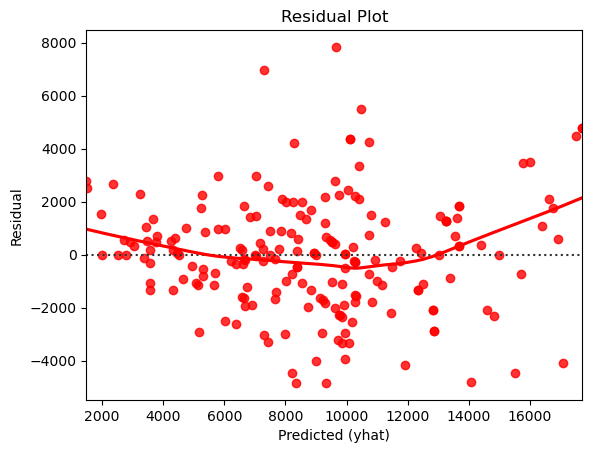

[('F statistic', 0.7776198289056071), ('P-value', 0.8338565454498786)]

In [218]:
df_summary = pd.DataFrame()
df_summary['Target (Actual y)'] = ytrain
df_summary['Predicted (yhat)'] = model14.fittedvalues
df_summary['Residual (y - yhat)'] = model14.resid
display(df_summary)
sns.residplot(
 data=df_summary,
 x='Predicted (yhat)',
 y='Residual (y - yhat)',
 color='red',
 lowess=True,
)
plt.xlabel('Predicted (yhat)')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()
name = ['F statistic', 'P-value']
test = sms.het_goldfeldquandt(df_summary['Residual (y - yhat)'], Xtrain)
lzip(name, test)


# Step 25: Conclusion

* Our model worked quite well with our training data with a final r^2 .742 and a final adjustd r^2 of .69 but did not perform well on test data as it clearly overfit the data
* We believe that a helpful explanatory variable would have been date purchased or years used as it would have given us a better understanding of the mileage which would inturn give us a better understanding of the asking price

I believe that even if companies had a good model to predict the asking price it would not help that much as because it is the asking price which does not correlate directly to the selling price and we dont have anything to show accidents and so that is not particuarly helpful.